In [1]:
#| label: app:interactive_sns_fig3

# %matplotlib inline

from src.cdk.analysis.cytosol import platereader as pr
import pandas as pd

import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt
import matplotlib as mpl

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Output

import src.cdk.logging

pr.plot_setup()

# load data and calculat SS values
data, platemap = pr.load_platereader_data("tests/test_data/cytation_dna_sweep.txt", "tests/test_data/platemap.csv")
kinetics = pr.kinetic_analysis(data);

Failed to solve: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Failed to solve: Optimal parameters not found: Number of calls to function has reached maxfev = 800.


In [8]:
def _plot_timedelta(plot: sns.FacetGrid | mpl.axes.Axes) -> sns.FacetGrid:
    axes = [plot]
    if isinstance(plot, sns.FacetGrid):
        axes = plot.axes.flatten()

    for ax in axes:
        # ax.xaxis.set_major_locator(timple.timedelta.AutoTimedeltaLocator(minticks=3))
        ax.xaxis.set_major_formatter(
            timple.timedelta.TimedeltaFormatter("%h:%m")
        )
        ax.set_xlabel("Time (hours)")

    # g.set_xlabels("Time (hours)")
    # g.figure.autofmt_xdate()

def plot_kinetics_by_well(
    data: pd.DataFrame,
    kinetics: pd.DataFrame,
    x: str = "Time",
    y: str = "Data",
    show_fit: bool = False,
    show_velocity: bool = False,
    annotate: bool = False,
    **kwargs,
):
    """
    Typical usage:

    > tk = kinetic_analysis(data=data, data_column="BackgroundSubtracted")
    > g = sns.FacetGrid(tk, col="Well", col_wrap=2, sharey=False, height=4, aspect=1.5)
    > g.map_dataframe(plot_kinetics, show_fit=True, show_velocity=True)
    """
    colors = sns.color_palette("Set2")

    ax = sns.scatterplot(data=data, x=x, y=y, color=colors[2], alpha=0.5)

    well = data["Well"].iloc[0]
    read = data["Read"].iloc[0]
    kinetics = kinetics.loc[well, read]
    if (kinetics.isna()).any():
        log.info(f"Kinetics information not available for {well}.")
        return

    ax_ylim = (
        ax.get_ylim()
    )  # Use this to run lines to bounds later, then restore them before returning.

    if show_fit:
        L = kinetics["Fit", "L"]
        k = kinetics["Fit", "k"]
        x0 = kinetics["Fit", "x0"]
        sns.lineplot(
            x=data["Time"],
            y=_sigmoid(data["Time"].dt.total_seconds(), L, k, x0),
            linestyle="--",
            color=colors[3],
            # alpha=0.5,
            ax=ax,
        )
    #     sns.lineplot(data=data, x=x, y=y, linestyle="--", c="red", alpha=0.5)

    # Max Velocity
    # maxV_x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    maxV_y = (
        kinetics["Velocity", "Max"]
        * (data["Time"] - kinetics["Velocity", "Time"]).dt.total_seconds()
        + kinetics["Velocity", "Data"]
    )

    sns.lineplot(
        x=data["Time"].loc[(maxV_y > 0) & (maxV_y < data[y].max())],
        y=maxV_y[(maxV_y > 0) & (maxV_y < data[y].max())],
        linestyle="--",
        color=colors[1],
        ax=ax,
    )

    maxV = kinetics["Velocity", "Max"]
    maxV_s = kinetics["Velocity", "Time"]
    maxV_d = kinetics["Velocity", "Data"]

    # decile_upper = summary[f"{y}_high_d"]
    # decile_lower = summary[f"{y}_low_d"]
    # ax.vlines(
    #     lag,
    #     ymin=ax_ylim[0],
    #     ymax=decile_lower,
    #     colors=colors[2],
    #     linestyle="--",
    # )

    # Time to Steady State
    ss_s = kinetics["Steady State", "Time"]
    ax.axvline(ss_s, c=colors[3], linestyle="--")

    # # Range
    # ax.axhline(decile_upper, c=colors[7], linestyle="--")
    # ax.axhline(decile_lower, c=colors[7], linestyle="--")

    if annotate:
        # Plot the text annotations on the chart
        ax.annotate(
            f"$V_{{max}} =$ {maxV:.2f} u/s",
            (maxV_s, maxV_d),
            xytext=(24, 0),
            textcoords="offset points",
            arrowprops={"arrowstyle": "->"},
            ha="left",
            va="center",
            c="black",
        )

        f = timple.timedelta.TimedeltaFormatter("%h:%m")
        lag_label = f.format_data(
            timple.timedelta.timedelta2num(kinetics["Lag", "Time"])
        )
        ax.annotate(
            f"$t_{{lag}} =$ {lag_label}",
            (kinetics["Lag", "Time"], kinetics["Lag", "Data"]),
            xytext=(12, 0),
            textcoords="offset points",
            ha="left",
            va="center",
        )

        ss_label = f.format_data(
            timple.timedelta.timedelta2num(kinetics["Steady State", "Time"])
        )
        ax.annotate(
            f"$t_{{steady state}} =$ {ss_label}",
            (
                kinetics["Steady State", "Time"],
                kinetics["Steady State", "Data"],
            ),
            xytext=(0, -12),
            textcoords="offset points",
            ha="left",
            va="top",
        )

    # Velocity
    if show_velocity:
        # Show a velocity sparkline over the plot
        velocity = (
            data.transform({y: "diff", x: lambda x: x}).rolling(5).mean()
        )
        velocity[y] = velocity[y]
        # velocity_ax = ax.secondary_yaxis(location="right",
        #                                  functions=(lambda x: pd.Series(x).rolling(5).mean().values, lambda x: x))
        velocity_ax = ax.twinx()
        sns.lineplot(data=velocity, x=x, y=y, alpha=0.5, ax=velocity_ax)
        velocity_ax.set_ylabel("$V (u/s)$")
        velocity_ax.set_ylim((0, velocity[y].max() * 2))

    ax.set_ylim(ax_ylim)

    _plot_timedelta(ax)

NameError: name 'mpl' is not defined

NameError: name '_plot_timedelta' is not defined

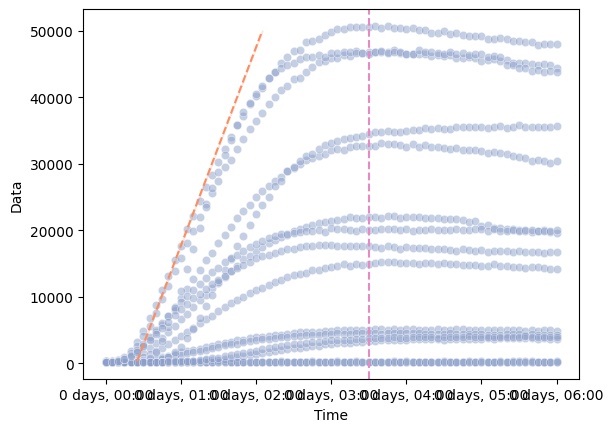

In [7]:
plot_kinetics_by_well(data, kinetics)